In [76]:
import datetime
import json
import os
import pathlib
from contextlib import contextmanager

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toolz
import yaml

from textrec.paths import paths

from IPython.display import display, HTML

In [77]:
pd.set_option('display.max_colwidth', 200)

# Find good examples from existing data

In [78]:
trial_level_data = pd.read_csv(
    paths.analyzed / f"combined_data.csv", dtype={"stimulus": str}
)

assert len(trial_level_data[trial_level_data["corrected_text"].isnull()]) == 0

# for col in "participant stimulus".split():
#     trial_level_data[col] = trial_level_data[col].astype("category")

# condition_type = pd.api.types.CategoricalDtype(
#     categories=["gated", "contextual", "standard", "norecs"], ordered=True
# )
# trial_level_data["condition"] = trial_level_data["condition"].astype(condition_type)


In [79]:
dataset = trial_level_data[['participant', 'stimulus', 'condition', 'corrected_text']].rename(columns={'corrected_text': 'text'})

In [80]:
def strip_uninformative(text):
    text = text.strip()
    for beginning in ['there is', 'there are', 'a view of', 'a photo of', 'a photo shows']:
        beginning = beginning + ' '
        if text.startswith(beginning):
            text = text[len(beginning):]
            return strip_uninformative(text)
    return text
dataset['text'] = dataset.text.str.strip().str.rstrip('.')
dataset['text'] = dataset.text.apply(strip_uninformative)

In [81]:
import wordfreq

dataset['num_words'] = [
    len(wordfreq.tokenize(text, 'en'))
    for text in dataset.text]

dataset['min_freq'] = [
    np.min([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
    for text in dataset.text]

dataset['mean_freq'] = [
    np.mean([wordfreq.zipf_frequency(tok, 'en') for tok in wordfreq.tokenize(text, 'en')])
    for text in dataset.text]

In [82]:
dataset['mean_rarity'] = (7 - dataset.mean_freq) / 7
dataset['total_rarity'] = dataset['mean_rarity'] * dataset['num_words']

In [83]:
dataset['predicted_details'] = dataset.num_words * 0.148274 + dataset.total_rarity * 1.198227

In [84]:
1.198227/7

0.1711752857142857

What is the marginal effect of adding an additional word?

0.148274 - .171175 zipf_freq(word)

In [85]:
with pd.option_context('display.max_colwidth', 500):
    display(dataset[dataset.num_words < 30].sort_values('predicted_details').iloc[-10:])

,participant,stimulus,condition,text,num_words,min_freq,mean_freq,mean_rarity,total_rarity,predicted_details
737,g55cwj,247576,standard,a bustling city street is filled with people and vehicles and a bus is driving through a zebra crossing towards the camera. the road is surrounded by majestic buildings,29,3.07,5.780690,0.174187,5.051429,10.352704
1731,533r6c,227326,norecs,an obvious dressed bride and groom at a wedding reception are cutting into their wedding cake with the help of the photographer whose hand is guiding theirs,27,3.58,5.614444,0.197937,5.344286,10.407065
1585,p45469,396295,norecs,a translucent sliding shower door with a red loofah hanging in the shower and a beige bath mat hanging on the silver rod on the door,26,2.04,5.513077,0.212418,5.522857,10.472761
735,g55cwj,240275,norecs,a lady is surfing towards the camera. her surfboard is white and is half submerged within the cresting wave. the water behind the wave is a bluish green,28,2.12,5.678929,0.188724,5.284286,10.483446
1282,x9m97g,236272,norecs,a batter completes his swing after hitting the baseball with the catcher ready for any incoming balls that come his way as his teammates in the dugout watch,28,3.01,5.666071,0.190561,5.335714,10.545069
1597,p4hxrf,396295,standard,this is a bathroom with a dirty shower door and a beige colored towel. there is a red shower sponge behind the door hanging on a shower caddy,28,2.98,5.650357,0.192806,5.398571,10.620386
228,5cgvvc,275449,norecs,a half-full glass of red wine is in the foreground while a gray tabby sits on a straw mat in the background looking inquisitively at the photographer,28,1.54,5.645000,0.193571,5.420000,10.646062
1657,wf82v8,396295,standard,"a closed, textured glass shower door with a tan colored towel hanging on the outside of the door and red loofa hanging on the inside shower wall",27,1.36,5.496296,0.214815,5.800000,10.953115
1793,7g8xw8,431140,standard,in a drab yellow bathroom is a very clinical white sink with an unadorned mirror above and adjacent white toilet with a roll of toilet paper on top,28,2.36,5.576786,0.203316,5.692857,10.973007
1791,7g8xw8,275449,standard,a curious orange and black cat with yellow eyes is crouched on a tan sisal rug and is partly obstructed by a half full glass of red wine,28,2.23,5.485714,0.216327,6.057143,11.409504


In [96]:
dataset.query('stimulus == "431140"').sort_values('num_words')

,participant,stimulus,condition,text,num_words,min_freq,mean_freq,mean_rarity,total_rarity,predicted_details
950,pr5hff,431140,gated,the bathroom sink,3,4.15,5.473333,0.218095,0.654286,1.228805
837,hx3m26,431140,gated,a toilet and sink,4,4.15,5.807500,0.170357,0.681429,1.409602
405,7q253f,431140,norecs,someone using the bathroom,4,4.50,5.832500,0.166786,0.667143,1.392485
453,88cv8q,431140,norecs,a bathroom is being unused,5,3.62,5.696000,0.186286,0.931429,1.857433
206,4vmgqv,431140,norecs,a toilet and bathroom sink,5,4.15,5.546000,0.207714,1.038571,1.985814
1053,r453r6,431140,norecs,"a typical, single occupant bathroom",5,3.17,4.998000,0.286000,1.430000,2.454835
201,4v7g27,431140,standard,a toilet and a sink,5,4.15,6.118000,0.126000,0.630000,1.496253
578,cf73g3,431140,standard,a bathroom with white furnishings,5,3.28,5.490000,0.215714,1.078571,2.033743
146,46gc8v,431140,gated,unwrapped toilet paper on toilet,5,2.52,4.620000,0.340000,1.700000,2.778356
525,9c8wwq,431140,standard,the old bathroom is very clean,6,4.50,5.996667,0.143333,0.860000,1.920119


That's mostly just the long descriptions. But I wonder if there are some words that characterize them that we could target.

Waaait.. what I really want is a _local_ measure of specificity. Can I predict the _overall_ specificity from a slice of, say, 5 words of the original?

# Aside, curiosity: is there any difference in this measure between writing conditions?

In [46]:
import seaborn as sns

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


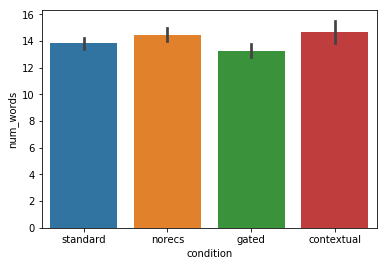

In [66]:
sns.barplot(x='condition', y='num_words', data=dataset)

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


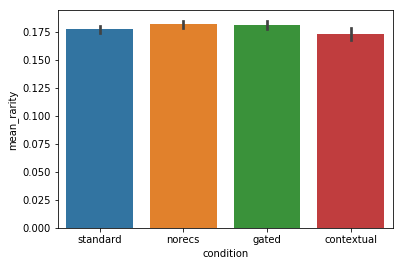

In [69]:
sns.barplot(x='condition', y='mean_rarity', data=dataset)

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


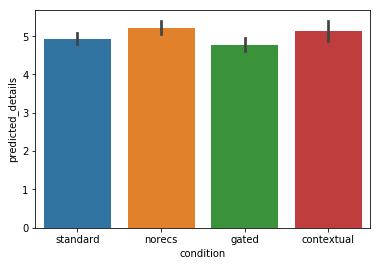

In [47]:
sns.barplot(x='condition', y='predicted_details', data=dataset)

In [48]:
import statsmodels.formula.api as smf

In [74]:
cond_levels = ['norecs', 'gated', 'standard', 'contextual']
smf.ols('mean_rarity ~ C(condition, levels=cond_levels) + C(stimulus)', data=dataset).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mean_rarity   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     12.22
Date:                Sat, 13 Oct 2018   Prob (F-statistic):           9.53e-28
Time:                        15:11:28   Log-Likelihood:                 3527.1
No. Observations:                1908   AIC:                            -7024.
Df Residuals:                    1893   BIC:                            -6941.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.1937      0.003     59.976      0.000       0.187       0.200
C(condition, levels=cond_levels)[T.gated]         -0.0004      0.002     -0.179      0.858      -0.005       0.004
C(condition, levels=cond_levels)[T.standard]      -0.0045      0.002     -2.078      0.038      -0.009      -0.000
C(condition, levels=cond_levels)[T.contextual]    -0.0097      0.003     -3.060      0.002      -0.016      -0.003
C(stimulus)[T.223777]                             -0.0239      0.004     -5.684      0.000      -0.032      -0.016
C(stimulus)[T.227326]                             -0.0143      0.004     -3.400      0.001      -0.023      -0.006
C(stimulus)[T.236272]                             -0.0137      0.004     -3.113      0.002      -0.022      -0.005
C(stimulus)[T.240275]                              0.0004      0.004      0.093      0.926      -0.008       0.009
C(stimulus)[T.247576]                             -0.0144      0.004     -3.429      0.001      -0.023      -0.006
C(stimulus)[T.275449]                             -0.0164      0.004     -3.899      0.000      -0.025      -0.008
C(stimulus)[T.280480]                             -0.0242      0.004     -5.522      0.000      -0.033      -0.016
C(stimulus)[T.396295]                              0.0091      0.004      2.159      0.031       0.001       0.017
C(stimulus)[T.431140]                             -0.0247      0.004     -5.871      0.000      -0.033      -0.016
C(stimulus)[T.527375]                             -0.0223      0.004     -5.093      0.000      -0.031      -0.014
C(stimulus)[T.71815]                              -0.0008      0.004     -0.184      0.854      -0.009       0.007
==============================================================================
Omnibus:                      235.708   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              500.089
Skew:                           0.744   Prob(JB):                    2.55e-109
Kurtosis:                       5.018   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
fit = smf.mixedlm(
    "predicted_details ~ C(condition)",
    data=dataset,
    groups=dataset['participant'],
    re_formula='1', vc_formula={'stimulus': '1 + C(condition)'}
).fit()
fit.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:              MixedLM  Dependent Variable:  predicted_details
No. Observations:   1908     Method:              REML             
No. Groups:         165      Scale:               1.5497           
Min. group size:    9        Likelihood:          -3439.7023       
Max. group size:    12       Converged:           Yes              
Mean group size:    11.6                                           
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 5.069    0.156 32.535 0.000  4.764  5.375
C(condition)[T.gated]    -0.251    0.145 -1.727 0.084 -0.535  0.034
C(condition)[T.norecs]    0.164    0.132  1.238 0.216 -0.095  0.423
C(condition)[T.standard] -0.126    0.132 -0.952 0.341 -0.385  0.133
Group RE                  1.552    0.210                           
stimulus RE               0.409    0.072                           
===================================================================

"""

In [56]:
dataset['predicted_details_z'] = dataset.predicted_details - dataset.groupby('stimulus').predicted_details.transform('mean')

In [63]:
mean_over_trials = dataset.groupby(['participant', 'condition']).predicted_details_z.mean().reset_index()

In [65]:
smf.ols('predicted_details_z ~ C(condition)', data=mean_over_trials).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     predicted_details_z   R-squared:                       0.012
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     1.974
Date:                 Sat, 13 Oct 2018   Prob (F-statistic):              0.117
Time:                         15:03:10   Log-Likelihood:                -940.56
No. Observations:                  495   AIC:                             1889.
Df Residuals:                      491   BIC:                             1906.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1579      0.221      0.714      0.475      -0.276       0.592
C(condition)[T.gated]       -0.3954      0.270     -1.467      0.143      -0.925       0.134
C(condition)[T.norecs]       0.0533      0.255      0.209      0.834      -0.447       0.554
C(condition)[T.standard]    -0.2248      0.255     -0.883      0.378      -0.725       0.276
==============================================================================
Omnibus:                      110.958   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.456
Skew:                           1.076   Prob(JB):                     2.33e-68
Kurtosis:                       6.236   Cond. No.                         7.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""